In [1]:
from pandas import read_csv
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#pip install -U scikit-learn


In [2]:
np.random.seed(20773)

pudahuel = pd.read_csv('Pudahuel Data/pudahuel-air-quality.csv', engine='python',
                       na_values=[' '])
pudahuel.replace('', np.nan, inplace=True)

pudahuel[' pm10'] = pudahuel[' pm10'].interpolate()
pudahuel[' o3'] = pudahuel[' o3'].interpolate()
pudahuel[' o3'] = pudahuel[' o3'] / 1000
pudahuel[' so2'] = pudahuel[' so2'].interpolate(method='linear', limit_direction='both')
pudahuel['date'] = pd.to_datetime(pudahuel['date']).dt.date
pudahuel.sort_values('date', inplace=True, ascending=False)
pudahuel.columns = ['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co']

print(pudahuel['so2'])


27      59.0
26      59.0
25      59.0
24      59.0
23      59.0
        ... 
3342    57.0
3341    57.0
3340    57.0
3339    57.0
3455    57.0
Name: so2, Length: 3457, dtype: float64


In [3]:
def juntar_datos_csv(nombre_carpeta, arreglo_columnas):
    # Obtiene la lista de todos los archivos que coinciden con el patrón
    csv_files = glob.glob(nombre_carpeta + "/*.csv")
    # Crea una lista para almacenar los DataFrames
    dfs = []

    # Lee cada archivo CSV y lo agrega a la lista de DataFrames
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, engine='python', sep=';',
                         usecols=arreglo_columnas)
        dfs.append(df)

    # Combina los DataFrames en uno solo
    return pd.concat(dfs)


# Ejemplo de uso de la función juntar_datos_csv
agua_caida = juntar_datos_csv("Pudahuel Data/Agua Caida", [3, 4])
presion_humedad = juntar_datos_csv("Pudahuel Data/Presion y Humedad",
                                   list(range(3, 10)))
radiacion = juntar_datos_csv("Pudahuel Data/Radiacion", [3, 4])
viento = juntar_datos_csv("Pudahuel Data/Viento", [3, 5, 6, 7, 8, 9])



## Formateo de data frames a datos por día

Para datos de Agua Caída

In [4]:
print(agua_caida)
agua_caida['momento'] = pd.to_datetime(agua_caida['momento'])
# Agregar una columna "date" que contenga solo la fecha (sin la hora)
agua_caida['date'] = agua_caida['momento'].dt.date
agua_caida_f = agua_caida.groupby('date')['rrInst'].sum()

                   momento  rrInst
0      2019-01-01 00:00:00     0.0
1      2019-01-01 00:01:00     0.0
2      2019-01-01 00:02:00     0.0
3      2019-01-01 00:03:00     0.0
4      2019-01-01 00:04:00     0.0
...                    ...     ...
44636  2023-05-31 23:56:00     0.0
44637  2023-05-31 23:57:00     0.0
44638  2023-05-31 23:58:00     0.0
44639  2023-05-31 23:59:00     0.0
44640  2023-06-01 00:00:00     0.0

[2447334 rows x 2 columns]


Para datos de Radiación

In [5]:
print(radiacion)
radiacion['momento'] = pd.to_datetime(radiacion['momento'])
# Agregar una columna "date" que contenga solo la fecha (sin la hora)
radiacion['date'] = radiacion['momento'].dt.date
# Obtener los valores máximos para cada día en las columnas especificadas
radiacion_f = radiacion.groupby('date')['radiacionGlobalInst'].max()
print(radiacion_f)

                   momento  radiacionGlobalInst
0      2019-05-01 00:00:00                  0.0
1      2019-05-01 00:01:00                  0.0
2      2019-05-01 00:02:00                  0.0
3      2019-05-01 00:03:00                  0.0
4      2019-05-01 00:04:00                  0.0
...                    ...                  ...
44636  2023-05-31 23:56:00                  0.0
44637  2023-05-31 23:57:00                  0.0
44638  2023-05-31 23:58:00                  0.0
44639  2023-05-31 23:59:00                  0.0
44640  2023-06-01 00:00:00                  0.0

[2142978 rows x 2 columns]
date
2019-05-01    770.6
2019-05-02    737.9
2019-05-03    781.2
2019-05-04    687.9
2019-05-05    699.3
              ...  
2023-05-28    510.3
2023-05-29    545.5
2023-05-30    464.4
2023-05-31    632.9
2023-06-01      0.0
Name: radiacionGlobalInst, Length: 1493, dtype: float64


Para datos del Viento

In [6]:
#print(viento)
viento['momento'] = pd.to_datetime(viento['momento'])
# Agregar una columna "date" que contenga solo la fecha (sin la hora)
viento['date'] = viento['momento'].dt.date
# Obtener los valores máximos para cada día en las columnas especificadas
#print(viento)
#print(viento.groupby('date').max())
viento_f = viento.groupby('date')[['ffInst', 'dd02Minutos', 'ff02Minutos',
                                   'dd10Minutos', 'ff10Minutos']].max()
print(viento_f)


            ffInst  dd02Minutos  ff02Minutos  dd10Minutos  ff10Minutos
date                                                                  
2019-05-01    12.6        360.0         10.6        360.0          9.4
2019-05-02    10.5        360.0         10.0        360.0          9.7
2019-05-03    13.0        360.0          9.2        360.0          8.0
2019-05-04    15.6        360.0         12.1        358.0         11.3
2019-05-05    11.7        360.0          9.7        360.0          7.9
...            ...          ...          ...          ...          ...
2023-05-28    12.1        360.0          9.5        360.0          8.5
2023-05-29    12.4        360.0         11.3        358.0         10.4
2023-05-30    11.1        360.0          8.6        360.0          8.1
2023-05-31    14.4        360.0         13.5        360.0         12.7
2023-06-01     3.1        333.0          3.1        337.0          2.5

[1493 rows x 5 columns]


In [7]:
presion_humedad['momento'] = pd.to_datetime(presion_humedad['momento'])
# Agregar una columna "date" que contenga solo la fecha (sin la hora)
presion_humedad['date'] = presion_humedad['momento'].dt.date
# Obtener los valores máximos para cada día en las columnas especificadas
presion_humedad_f = presion_humedad.groupby('date')[['hr', 'p0', 'qfe1', 'qfe2', 'qff']]\
                                .mean().reset_index()
presion_humedad_f['qfe2'] = presion_humedad_f['qfe2'].interpolate(
    method='linear', limit_direction='backward', axis=0)
print(presion_humedad_f)


            date         hr          p0        qfe1        qfe2          qff
0     2019-05-01  46.929167  962.261467  962.062257  960.771935  1017.741409
1     2019-05-02  35.030556  959.350694  959.150694  960.771935  1014.183472
2     2019-05-03  48.330556  957.909236  957.709236  960.771935  1012.564444
3     2019-05-04  72.917361  959.916806  959.716806  960.771935  1015.108403
4     2019-05-05  76.053472  962.057986  961.857986  960.771935  1017.477500
...          ...        ...         ...         ...         ...          ...
1488  2023-05-28  75.362500  963.748611  963.548931  963.728611  1020.074271
1489  2023-05-29  64.527778  962.370694  962.173764  962.350694  1017.812146
1490  2023-05-30  60.300000  962.908819  962.710889  962.888819  1018.731028
1491  2023-05-31  65.297222  963.702014  963.504757  963.682014  1019.509833
1492  2023-06-01  51.000000  961.600000  961.400000  961.580000  1017.070000

[1493 rows x 6 columns]


## Construccion Data Frame con todos los datos por fecha


In [8]:
final_df = pudahuel.merge(viento_f, on='date')
final_df = final_df.merge(presion_humedad_f, on='date')
final_df = final_df.merge(agua_caida_f, on='date')
final_df = final_df.merge(radiacion_f, on='date')
print(final_df)
print(final_df.columns)



            date   pm25   pm10     o3   no2        so2    co  ffInst  \
0     2023-06-01  153.0   89.0  0.014  40.0  59.000000  18.0     3.1   
1     2023-05-31  155.0   97.0  0.016  48.0  59.000000  19.0    14.4   
2     2023-05-30  134.0   97.0  0.018  49.0  59.000000  17.0    11.1   
3     2023-05-29  142.0   79.0  0.020  36.0  59.000000  13.0    12.4   
4     2023-05-28   90.0  120.0  0.008  27.0  59.000000  13.0    12.1   
...          ...    ...    ...    ...   ...        ...   ...     ...   
1486  2019-05-05   61.0   58.0  0.022  32.0  64.359885  13.0    11.7   
1487  2019-05-04   70.0   55.0  0.019  27.0  64.341547   8.0    15.6   
1488  2019-05-03  100.0   74.0  0.018  40.0  64.323209  10.0    13.0   
1489  2019-05-02  117.0   87.0  0.015  59.0  64.304871  15.0    10.5   
1490  2019-05-01   77.0   86.0  0.033  45.0  64.286533  16.0    12.6   

      dd02Minutos  ff02Minutos  dd10Minutos  ff10Minutos         hr  \
0           333.0          3.1        337.0          2.5  51.000

Los rangos y ponderaciones utilizados en el cálculo del Índice de Calidad del Aire de Santiago (ICAS) son definidos por la normativa chilena y están diseñados para evaluar la concentración de contaminantes atmosféricos y asignarles un valor numérico representativo de su nivel de riesgo para la salud humana y el medio ambiente.

Los rangos representan los límites o umbrales establecidos para cada contaminante. Por ejemplo, para el PM2.5, los rangos indican los intervalos de concentración que van desde niveles bajos hasta niveles peligrosos. Estos rangos pueden variar según el contaminante y la normativa vigente.

Las ponderaciones son los valores asignados a cada rango de concentración para determinar la contribución de cada contaminante al índice final. Estas ponderaciones suelen reflejar la importancia relativa de cada contaminante en términos de su impacto en la salud humana y el medio ambiente. Por ejemplo, se pueden asignar ponderaciones más altas a los contaminantes que tienen un mayor impacto en la calidad del aire y en la salud de las personas.

In [9]:
# dataset = dataframe.values
# dataset = dataset.astype('float32')
# numpy.shape(dataset)
print(final_df.columns)


# Función para calcular el AQI
def calcular_ica_polucion(cp, pollutant):
    # Definir los puntos de interrupción y los rangos de AQI
    breakpoints = {
        'o3': [(0, 0.054), (0.055, 0.070), (0.071, 0.085), (0.086, 0.105),
                (0.106, 0.200), (0.201, 0.504)],
        'pm25': [(0, 12.0), (12.1, 35.4), (35.5, 55.4), (55.5, 150.4),
                 (150.5, 250.4), (250.5, 500.4)],
        'pm10': [(0, 54), (55, 154), (155, 254), (255, 354), (355, 424),
                 (425, 604)],
        'co': [(0, 4.4), (4.5, 9.4), (9.5, 12.4), (12.5, 15.4),
               (15.5, 30.4), (30.5, 50.4)],
        'so2': [(0, 35), (36, 75), (76, 185), (186, 304), (305, 604),
                (605, 1004)],
        'no2': [(0, 53), (54, 100), (101, 360), (361, 649),
                (650, 1249), (1250, 2049)]
    }
    rangos_ica = [(0, 50), (51, 100), (101, 150), (151, 200),
                  (201, 300), (301, 500)]
    for i, (bp_lo, bp_hi) in enumerate(breakpoints[pollutant]):
        if bp_lo <= cp <= bp_hi:
            i_lo, i_hi = rangos_ica[i]
            ip = ((i_hi - i_lo) / (bp_hi - bp_lo)) * (cp - bp_lo) + i_lo
            return round(ip)
    return np.nan


def calcular_polucion(df):
    # Calcular el AQI para cada contaminante y cada fila
    for pollutant in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']:
        df[f'{pollutant}_ica'] = df[pollutant].apply(
            calcular_ica_polucion, pollutant=pollutant)

    # Calcular el AQI para cada fila
    df['ICA'] = df[[f'{pollutant}_ica'
                                for pollutant in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']]].max(axis=1)
    return df


final_df = calcular_polucion(final_df)

# Supongamos que tienes un DataFrame llamado df que contiene los datos de pm25, pm10, o3, no2 y co

test = 10

print(final_df.query("ICA > @test"))

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'ffInst',
       'dd02Minutos', 'ff02Minutos', 'dd10Minutos', 'ff10Minutos', 'hr', 'p0',
       'qfe1', 'qfe2', 'qff', 'rrInst', 'radiacionGlobalInst'],
      dtype='object')
            date   pm25   pm10     o3   no2        so2    co  ffInst  \
0     2023-06-01  153.0   89.0  0.014  40.0  59.000000  18.0     3.1   
1     2023-05-31  155.0   97.0  0.016  48.0  59.000000  19.0    14.4   
2     2023-05-30  134.0   97.0  0.018  49.0  59.000000  17.0    11.1   
3     2023-05-29  142.0   79.0  0.020  36.0  59.000000  13.0    12.4   
4     2023-05-28   90.0  120.0  0.008  27.0  59.000000  13.0    12.1   
...          ...    ...    ...    ...   ...        ...   ...     ...   
1486  2019-05-05   61.0   58.0  0.022  32.0  64.359885  13.0    11.7   
1487  2019-05-04   70.0   55.0  0.019  27.0  64.341547   8.0    15.6   
1488  2019-05-03  100.0   74.0  0.018  40.0  64.323209  10.0    13.0   
1489  2019-05-02  117.0   87.0  0.015  59.0  64.

In [10]:
# Function to create the dataset
# Equation f(yt) = f(yt-5)
# Convert an array of values into a dataset matrix

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg



### Funcion para desplazar en un intervalo los datos

In [11]:
# Funcion que crea un dataframe con los valores desplazados en un
#  intervalo de tiempo de un data frame entregado
def create_interval_shifted_dataset(df, start, end, keep_column):
    df = df.sort_values(by='date')
    columns = df.columns.tolist()
    columns.remove(keep_column)
    columns.remove('date')

    dfs_auxiliares = {}
    for n in range(start, end + 1):
        dfs_auxiliares[n] = df.set_index('date').shift(n).reset_index()
    new_data = []
    for i, row in df.iterrows():
        current_date = row['date']
        new_row = {}

        for n in range(start, end + 1):
            df_auxiliar = dfs_auxiliares[n]
            df_filtrado = df_auxiliar[df_auxiliar['date'] == current_date]

            if not df_filtrado.empty:
                for column in columns:
                    column_name = f"{column}(t-{n})"
                    new_row[column_name] = df_filtrado.at[df_filtrado.index[0], column]

        if new_row:
            new_row[keep_column + "(t)"] = row[keep_column]
            new_row['date'] = current_date
            new_data.append(new_row)

    return pd.DataFrame(new_data)

In [12]:
model_df = final_df.copy()
print(model_df.columns)
model_df.drop(['pm25_ica', 'pm10_ica', 'o3_ica', 'no2_ica', 'so2_ica',
               'co_ica', 'rrInst'], axis=1, inplace=True)

model_df = create_interval_shifted_dataset(model_df, 5, 10, 'ICA')
model_df = model_df.dropna()
print(model_df)
model_df.dropna(inplace=True)
model_df.drop(['date'], axis=1, inplace=True)


Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'ffInst',
       'dd02Minutos', 'ff02Minutos', 'dd10Minutos', 'ff10Minutos', 'hr', 'p0',
       'qfe1', 'qfe2', 'qff', 'rrInst', 'radiacionGlobalInst', 'pm25_ica',
       'pm10_ica', 'o3_ica', 'no2_ica', 'so2_ica', 'co_ica', 'ICA'],
      dtype='object')


      pm25(t-5)  pm10(t-5)  o3(t-5)  no2(t-5)   so2(t-5)  co(t-5)  \
10         72.0       72.0    0.017      47.0  64.378223     12.0   
11         88.0       66.0    0.020      29.0  64.396562      6.0   
12         80.0       55.0    0.013      26.0  64.414900      6.0   
13         79.0       46.0    0.019      27.0  64.433238      7.0   
14         71.0       65.0    0.024      44.0  64.451576     12.0   
...         ...        ...      ...       ...        ...      ...   
1486       80.0       78.0    0.005      30.0  59.000000     15.0   
1487      121.0       59.0    0.003      23.0  59.000000     14.0   
1488       92.0       73.0    0.005      27.0  59.000000     13.0   
1489      117.0       46.0    0.007      22.0  59.000000      7.0   
1490       72.0       57.0    0.013      24.0  59.000000      9.0   

      ffInst(t-5)  dd02Minutos(t-5)  ff02Minutos(t-5)  dd10Minutos(t-5)  ...  \
10           13.4             360.0              12.9             360.0  ...   
11         

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
print(model_df.shape)
model_df = scaler.fit_transform(model_df)
print(model_df.shape)

(1372, 103)
(1372, 103)


In [14]:
# split into train and test sets
train_size = int(len(model_df) * 0.8)
test_size = len(model_df) - train_size
train, test = model_df[0:train_size], model_df[train_size:len(model_df)]
print(len(train), len(test))

1097 275


In [15]:
#train = train.drop(train.columns[list(range(89, 107))], axis=1)
#train.columns = ['pm25(t-5)', 'pm10(t-5)', 'o3(t-5)', 'no2(t-5)', 'so2(t-5)',
#                 'co(t-5)', 'ffInst(t-5)', 'dd02Minutos(t-5)', 'ff02Minutos(t-5)',
#                 'dd10Minutos(t-5)', 'ff10Minutos(t-5)', 'hr(t-5)', 'p0(t-5)',
#                 'qfe1(t-5)', 'qfe2(t-5)', 'qff(t-5)', 'rrInst(t-5)',
#                 'radiacionGlobalInst(t-5)', 'ICA']

# Normalizar los datos


#train = scalerTrain.fit_transform(train)
#train = train.values

train_x, train_y = train[:, :-1], train[:, -1]
print(train_x.shape, train_y.shape)


#test = test.drop(test.columns[list(range(89, 107))], axis=1)
#test.columns = ['pm25(t-5)', 'pm10(t-5)', 'o3(t-5)', 'no2(t-5)', 'so2(t-5)',
#               'co(t-5)', 'ffInst(t-5)', 'dd02Minutos(t-5)', 'ff02Minutos(t-5)',
#               'dd10Minutos(t-5)', 'ff10Minutos(t-5)', 'hr(t-5)', 'p0(t-5)',
#              'qfe1(t-5)', 'qfe2(t-5)', 'qff(t-5)', 'rrInst(t-5)',
#             'radiacionGlobalInst(t-5)', 'ICA']

#test = create_interval_shifted_dataset(test, 5, 10, 'ICA')
#test.drop(['date'], axis=1, inplace=True)
#test.dropna(inplace=True)
#test = test.values
test_x, test_y = test[:, :-1], test[:, -1]
#test_x = scalerX.fit_transform(test_x)
#test_y = scalerY.fit_transform(test_y.reshape(-1, 1))
print(test.shape)

#test = test.values


(1097, 102) (1097,)
(275, 103)


(1097, 102, 1) (1097, 1) (275, 102, 1) (275,)
102 1


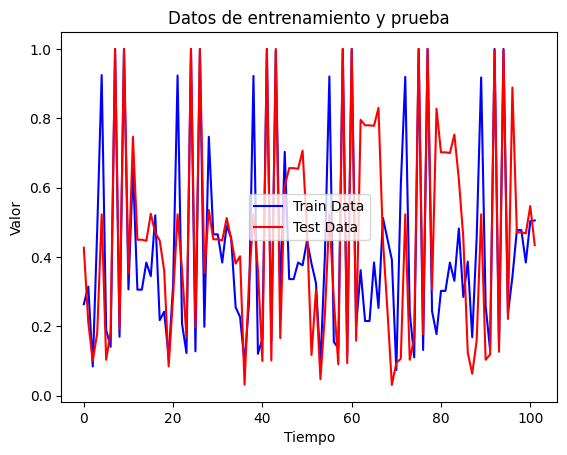

In [56]:
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
test_x = test_x.reshape((test_x.shape[0], train_x.shape[1], 1))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
print(train_x.shape[1], train_x.shape[2])

# Graficar train_x y test_x
plt.figure()
plt.plot(range(train_x.shape[1]), train_x[0, :, 0], 'b-', label='Train Data')
plt.plot(range(test_x.shape[1]), test_x[0, :, 0], 'r-', label='Test Data')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Datos de entrenamiento y prueba')
plt.legend()
plt.show()


In [51]:
# create and fit the LSTM network
from tensorflow.keras import optimizers
batch_size = 1
model = Sequential()
print(train_x.shape[1])
model.add(LSTM(10, batch_input_shape=(batch_size, 102, 1), return_sequences=False, stateful=True))
model.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.009)
model.compile(loss='mean_squared_error', optimizer=adam)


102


In [61]:
model2 = Sequential()
model2.add(LSTM(32, return_sequences=True,
               input_shape=(102, 1)))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32))  # return a single vector of dimension 32
model2.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.009)
model2.compile(loss='mean_squared_error', optimizer=adam)

In [62]:
#model2
history  = model2.fit(train_x, train_y, epochs=100, batch_size=32, validation_data=(test_x, test_y), verbose=1, shuffle=False)

Epoch 1/100
35/35 [==============================] - 12s 114ms/step - loss: 0.0301 - val_loss: 0.0083
Epoch 2/100
35/35 [==============================] - 3s 76ms/step - loss: 0.0229 - val_loss: 0.0093
Epoch 3/100
35/35 [==============================] - 3s 75ms/step - loss: 0.0207 - val_loss: 0.0085
Epoch 4/100
35/35 [==============================] - 3s 75ms/step - loss: 0.0208 - val_loss: 0.0085
Epoch 5/100
35/35 [==============================] - 3s 75ms/step - loss: 0.0206 - val_loss: 0.0085
Epoch 6/100
35/35 [==============================] - 3s 78ms/step - loss: 0.0204 - val_loss: 0.0086
Epoch 7/100
35/35 [==============================] - 3s 75ms/step - loss: 0.0202 - val_loss: 0.0087
Epoch 8/100
35/35 [==============================] - 3s 75ms/step - loss: 0.0199 - val_loss: 0.0088
Epoch 9/100
35/35 [==============================] - 3s 73ms/step - loss: 0.0198 - val_loss: 0.0095
Epoch 10/100
35/35 [==============================] - 3s 74ms/step - loss: 0.0187 - val_loss: 0.01

Epoch 1/15
1097/1097 - 17s - loss: 0.0116 - 17s/epoch - 16ms/step
Epoch 2/15
1097/1097 - 15s - loss: 0.0109 - 15s/epoch - 14ms/step
Epoch 3/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoch 4/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoch 5/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoch 6/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoch 7/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 14ms/step
Epoch 8/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoch 9/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 14ms/step
Epoch 10/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 14ms/step
Epoch 11/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 14ms/step
Epoch 12/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 14ms/step
Epoch 13/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 14ms/step
Epoch 14/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoch 15/15
1097/1097 - 15s - loss: 0.0111 - 15s/epoch - 13ms/step
Epoc

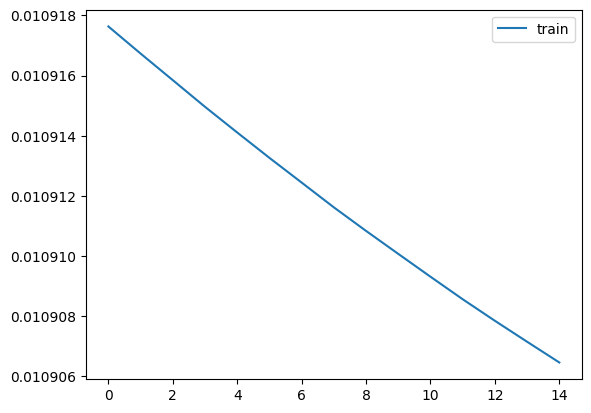

In [52]:
from matplotlib import pyplot as plt
#pytest
for i in range(10):
    history = model.fit(train_x, train_y, epochs=15, batch_size= batch_size, verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [58]:
# make predictions
train_predict = model.predict(train_x)
print(train_predict.shape)



TypeError: in user code:

    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\rnn\lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_52' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_52' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [60]:
model.reset_states()
print(test_x.shape)
test_predict = model.predict(test_x)

(275, 102, 1)


TypeError: in user code:

    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mtora\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\rnn\lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_52' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_52' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [68]:

#model2.reset_states()
print(test_x.shape)
test_predict = model2.predict(test_x)

(275, 102, 1)
1/9 [==>...........................] - ETA: 0s

9/9 [==============================] - 0s 23ms/step


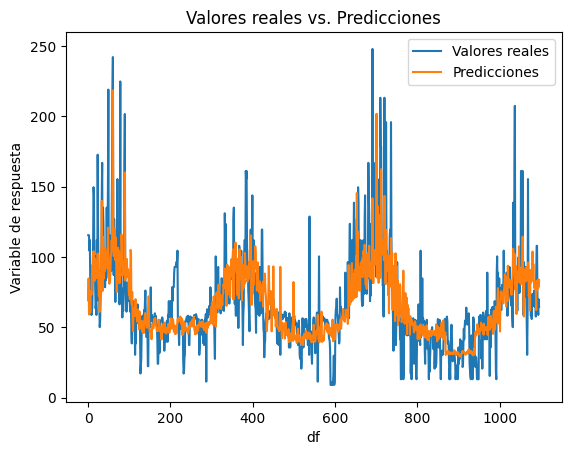

Train Score: 22.92 RMSE


In [64]:
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1]))
train_predict = np.concatenate((train_predict, train_x), axis=1)
train_predict = scaler.inverse_transform(train_predict)
train_predict = train_predict[:, 0]

train_y = train_y.reshape(len(train_y), 1)
data_entrenamiento_y = np.concatenate((train_y, train_x), axis=1)
data_entrenamiento_y = scaler.inverse_transform(data_entrenamiento_y)
data_entrenamiento_y = data_entrenamiento_y[:, 0]

# Graficar los valores reales
plt.plot(data_entrenamiento_y, label='Valores reales')

# Graficar las predicciones
plt.plot(train_predict, label='Predicciones')

plt.xlabel('df')
plt.ylabel('Variable de respuesta')
plt.title('Valores reales vs. Predicciones')
plt.legend()
plt.show()

train_score = math.sqrt(mean_squared_error(data_entrenamiento_y, train_predict))
print('Train Score: %.2f RMSE' % (train_score))

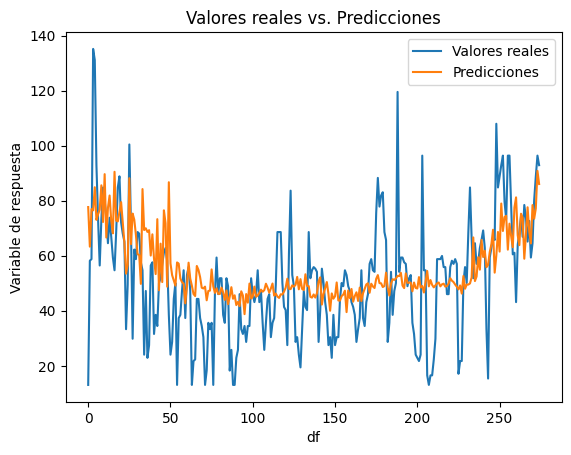

Test Score: 19.00 RMSE


In [69]:
# invert predictions
# Arreglo shatgipti
#pred_prueba_y = test_predict.reshape(test_predict.shape[0], test_predict.shape[1])
test_X = test_x.reshape((test_x.shape[0], test_x.shape[1]))
pred_prueba_y = np.concatenate((test_predict, test_X), axis=1)
pred_prueba_y = scaler.inverse_transform(pred_prueba_y)
pred_prueba_y = pred_prueba_y[:, 0]

test_Y = test_y.reshape(len(test_y), 1)
data_prueba_y = np.concatenate((test_Y, test_X), axis=1)
data_prueba_y = scaler.inverse_transform(data_prueba_y)
data_prueba_y = data_prueba_y[:, 0]

# Graficar los valores reales
plt.plot(data_prueba_y, label='Valores reales')

# Graficar las predicciones
plt.plot(pred_prueba_y, label='Predicciones')

plt.xlabel('df')
plt.ylabel('Variable de respuesta')
plt.title('Valores reales vs. Predicciones')
plt.legend()
plt.show()


test_score = math.sqrt(mean_squared_error(data_prueba_y, pred_prueba_y))
print('Test Score: %.2f RMSE' % (test_score))